## This script combines data from all participants and plots it onto topoplots, pre-post and post-pre response

In [221]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
import numpy.matlib
import scipy.stats as stats 
sns.set_theme() # set the plotting atmosphere

In [222]:
crayons = sns.color_palette("hls", 8)

In [223]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


In [224]:
def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    #axes[0].set_title(f'{title_In}', fontsize = 20)
    #axes[1].set_title(f'{title_In}', fontsize = 20)
    return fig, axes

def init_TopoTemplate_3Plots(title_In):
    """Prep topo plot fig and axes"""
    #fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))#,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6),gridspec_kw=dict(height_ratios=[3]), layout = 'constrained')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    axes[2].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    #axes[0].set_title(f'{title_In}', fontsize = 20)
    #axes[1].set_title(f'{title_In}', fontsize = 20)
    return fig, axes

In [225]:
NumBins = 6
NumChans = 128
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']
cll=['1%', '3%', '5%', '16%', '40%', '100%']
ttl = ['2f1','4f1','6f1','8f1','2f2','4f2','6f2','8f2']
elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,     72]
AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
#AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
AnalysisChans = np.unique(AllAnalysisChans) - 1
VisChans = np.sort(AnalysisChans)
print(f'Channels to be visualized: {VisChans}')
ch_list = np.arange(0,NumChans,1)
ocm = np.zeros_like((ch_list))
ocm[VisChans] = True # set good chans to true
ocm_chans = ocm.astype(bool)

Channels to be visualized: [30 36 41 46 50 51 52 53 54 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97]


In [226]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {(dataFileNames)}')
##############################################
FileN = dataFileNames[6]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: ['AllSubj_MatFiles_C1_20240412_110418.pkl', 'AllSubj_MatFiles_C1_20240422_162530.pkl', 'AllSubj_MatFiles_C1_20240502_141234.pkl', 'AllSubj_MatFiles_ri_C1_20240502_143216.pkl', 'AllSubj_MatFiles_ri_C1_20240502_151155.pkl', 'CleanProcessed_Data_pnlApproved_20240528_143746.pkl', 'Clean_Procc_Data_pnlApproved_20240528_143903.pkl', 'ComplexVals_AllSubs_20240516_121757.pkl', 'ComplexVals_AllSubs_20240516_121917.mat', 'ComplexVals_AllSubs_20240516_122240.mat', 'ComplexVals_AllSubs_20240516_122723.pkl', 'EEG_Fully_ProcessedData_20240509_195111.pkl', 'ProcessedData_pnlApproved_20240514_190735.pkl', 'Processedf1_Data_pnlApproved_20240528_140901.pkl', 'Processedf2_Data_pnlApproved_20240528_141408.pkl']
Current WD: C:\plimon\LTP_analysis\eegMatFiles\AllMat\Clean_Procc_Data_pnlApproved_20240528_143903.pkl
Does File #1 Exist? True


In [227]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())

dict_keys(['RealImaginaryData_sIns', 'EEGData', 'SubIDs'])


In [228]:
xFxData = loadData['EEGData']
FileName = loadData['SubIDs']

### get indicies to seperate Potentiated Stimulus, Attention Congruent and Non-potentiated stimulus, Attention Incongruent 

In [229]:
FileName = [FileName.replace('_','-') for FileName in FileName]
FileName = [s[3:] for s in FileName]

In [230]:
NumFiles = int(len(FileName))
# Find How Many Subject Names There are ...
string_ind = '-'
uniqueSubs = []
SessFileType = []
'for each file name, get sub ID and also session record'
for n in range(NumFiles):
    x = FileName[n] # single file name string ie: 'nl-xxxx_attnX'
    if string_ind in x:
        y = x.split(string_ind)[0] # get subj number
        #print(y)
        z = x.split(string_ind)[1] # get session condition name 
        #print(z)
        # from each session name extract import info that will help us index and exclude later on ..
        uniqueSubs.append(y) # store all participant numbers (repeating - will be sorted later)
        SessFileType.append(z) # store the condtion label

In [231]:
print(f'Subject IDs: {uniqueSubs}')
print(f' Conditions: {SessFileType[0:2]}')

Subject IDs: ['2651', '2651', '2653', '2653', '2654', '2654', '2655', '2655', '2657', '2657', '2658', '2658', '2659', '2659', '2660', '2664', '2664', '2665', '2665', '2666', '2666', '2667', '2667', '2668', '2668', '2670', '2670', '2672', '2672', '2674', '2674', '2676', '2677', '2677', '2678', '2695', '2695', '2696', '2696', '2697', '2697', '2708', '2715', '2716', '2726', '2727', '2728', '2728', '2733', '2734', '345202', '345202', '345215', '345215', '345216', '345216']
 Conditions: ['attnL', 'attnR']


In [232]:
# given double sessions.., how many unique participants do we have?
TotalFiles = np.array(uniqueSubs)
[NumSubs, SessCounts] = np.unique(TotalFiles, return_counts = True) # returns unique subject and how many sessions they did (should be 2)
print(f'Total Participants: {len(NumSubs)}')
[FileQuants, TotSess] = np.unique(SessCounts, return_counts = True) # returns counts of how many subs did 1 session and 2 sessions 

Total Participants: 33


In [233]:
TwoSess = SessCounts == 2 # index of who completed 2 sessions ..
CleanSubjs = NumSubs[TwoSess] # subs who completed 2 sessions 
SingleSubs = NumSubs[~TwoSess] # subs who did not complete 2 sessions 

In [234]:
print(f'{len(CleanSubjs)} Participants Completed AttnL and AttnR')
print(f'{len(SingleSubs)} Participants did not complete both sessions')

23 Participants Completed AttnL and AttnR
10 Participants did not complete both sessions


In [235]:
NumSubs = int(len(FileName))
print(f'Total Number of Data Files: {NumSubs}')

# str_catch = '-'
# SubjID = np.array([file_name.split(str_catch)[1] for file_name in FileName])
# AttnX_Condition = np.array([file_name.split(str_catch)[2] for file_name in FileName])

Total Number of Data Files: 56


##### Find location of data files: *Attention-Congruent, Attention-Incongruent*

In [236]:
SubjectNames = np.concatenate ((CleanSubjs,SingleSubs)) # combine subs once time, regardless of double session or single session 
FileLocationInv = np.zeros((int(len(SubjectNames)),2)) # store file locations for both attnCong and atnIncong

In [237]:
for sn in range(len(SubjectNames)):
    fileNameIn = SubjectNames[sn]#CleanSubjs[i]
    print(f'importing subject {fileNameIn}s data ...')
    SubjFile_Pos = [(i, x) for i, x in enumerate(FileName) if fileNameIn in x]

    if len(SubjFile_Pos) == 2:
        pos1 = SubjFile_Pos[0][0]
        pos2 = SubjFile_Pos[1][0]

        FileLocationInv[sn,:] = int(pos1), int(pos2)

    else:
        print(f'Subject {fileNameIn} only has one file ...')
        #print(f'{SubjFile_Pos}')
        posx = SubjFile_Pos[0][0] # get experiment name 
        AttnPot_Cond = SubjFile_Pos[0][1].split(string_ind)[1] # get AttnX label

        if AttnPot_Cond == 'attnL':
            print(f'and session {AttnPot_Cond} was completed only')

            FileLocationInv[sn,:] = posx, np.nan

        else:
            print(f'and session {AttnPot_Cond} was completed only')
            FileLocationInv[sn,:] = np.nan, posx
    print(f'done finding file locations!')
print(FileLocationInv)

importing subject 2651s data ...
done finding file locations!
importing subject 2653s data ...
done finding file locations!
importing subject 2654s data ...
done finding file locations!
importing subject 2655s data ...
done finding file locations!
importing subject 2657s data ...
done finding file locations!
importing subject 2658s data ...
done finding file locations!
importing subject 2659s data ...
done finding file locations!
importing subject 2664s data ...
done finding file locations!
importing subject 2665s data ...
done finding file locations!
importing subject 2666s data ...
done finding file locations!
importing subject 2667s data ...
done finding file locations!
importing subject 2668s data ...
done finding file locations!
importing subject 2670s data ...
done finding file locations!
importing subject 2672s data ...
done finding file locations!
importing subject 2674s data ...
done finding file locations!
importing subject 2677s data ...
done finding file locations!
importin

In [238]:
# pre load empty df to feed for missing files 
emptyMat = np.zeros((2,6,128))
emptyMat[:] = np.nan
# dyanmic parameters that will be iterable in near future
sIndex = 10
Harmonic = 0
Harmonic2 = Harmonic + 4
# import file locations 
FPositions = FileLocationInv[sIndex,:]

if not np.isnan(FPositions).any():
    print('All Files present')
    'Here we find Session 1: F1,F2 data and Session 2: F1,F2 data '
    #SubjDataSet = [xFxData[FPositions[0]][Harmonic] ,xFxData[FPositions[1]][Harmonic]] # each contains 2 6 128
    'Attn Congruent F1, F2 & Attn Incongruent F1, F2'
    SubjDataSet = [xFxData[FPositions[0]][Harmonic],
                   xFxData[FPositions[0]][Harmonic2],
                   xFxData[FPositions[1]][Harmonic],
                   xFxData[FPositions[1]][Harmonic2]]

else:
    print(f'only one file avilable')
    if np.isnan(FPositions[0]):
        print(f'AttnL data is absent')
        'Empty Attn Congruent F1, F2 & Attn Incongruent F1, F2'
        SubjDataSet = [emptyMat,
                       emptyMat,
                         xFxData[FPositions[1]][Harmonic],
                         xFxData[FPositions[1]][Harmonic2]]

    else:
        print(f'AttnR data is absent')
        'Attn Congruent F1, F2                                                             | Empty Attn Incongruent F1, F2'
        SubjDataSet = [xFxData[FPositions[0]][Harmonic],
                       xFxData[FPositions[0]][Harmonic2],
                       emptyMat,
                       emptyMat]

All Files present


In [239]:
print(len(SubjDataSet))

4


In [242]:
store = []

for sds in range(len(SubjDataSet)):
    #Diffdf = np.zeros((NumBins,NumChans))

    dfIn = np.array(SubjDataSet[sds]) # 2 x 6 x 128
    print(dfIn.shape)

    preVals = dfIn[0,:,:]
    postVals = dfIn[1,:,:]

    Diffdf = np.subtract(postVals,preVals)

    store.append(Diffdf)


(2, 6, 128)
(2, 6, 128)
(2, 6, 128)
(2, 6, 128)


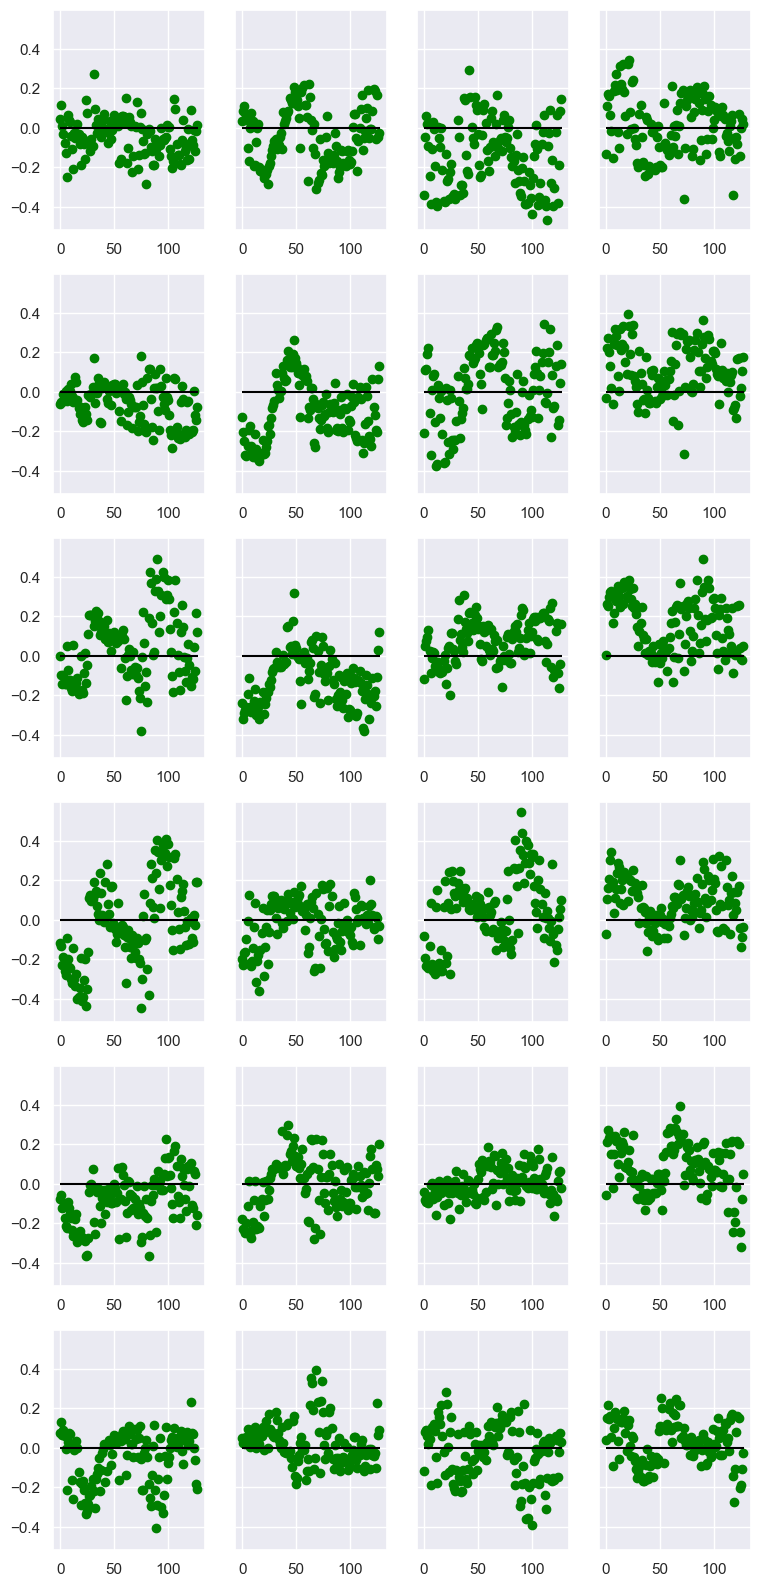

In [256]:
x_Chaxis = np.arange(0,NumChans,1)
fig,axs = plt.subplots(6,4,figsize = ((9,20)), sharey= True)
for hemiDiffs in range(4):
    hemiData = np.array(store[hemiDiffs])
    for b in range(NumBins):
        axs[b,hemiDiffs].scatter(x_Chaxis, hemiData[b,:], color = 'green')
        axs[b,hemiDiffs].hlines(0,xmin = 0,xmax = 128, color = 'black')


# print(store[0].shape)

In [ ]:
def GetDiffsPerCo(SubjDataSet):
    attnCong_ds = np.array(SubjDataSet[0]) # Attention Congruent 
    attnIncong_ds = np.array(SubjDataSet[1])# Attention Incgongruent

    ac_Diffs = np.subtract(attnCong_ds[1,:,:],attnCong_ds[0,:,:])
    acinc_Diffs = np.subtract(attnIncong_ds[1,:,:],attnIncong_ds[0,:,:])

    return ac_Diffs, acinc_Diffs

In [ ]:
ac,ai = GetDiffsPerCo(SubjDataSet)

In [ ]:
print(ac.shape)
print(ai.shape)

In [ ]:
fig,axs = plt.subplots(1,2,figsize = (12,6),sharey = True)
for b in range(NumBins):
    acd = ac[b,:]
    aid = ai[b,:]

    axs[0].scatter(np.arange(0,NumChans,1),acd, label = f'Bin #: {b+1}')
    axs[0].hlines(0,xmin = 0,xmax = 128, color = 'black')
    axs[0].set_title(f'Attention Induction Congruent Data')
    axs[0].legend(loc = 'upper left')

    axs[1].scatter(np.arange(0,NumChans,1),aid, label = f'Bin #: {b+1}')
    axs[1].hlines(0,xmin = 0,xmax = 128, color = 'black')
    #axs[1].legend()

In [ ]:
GetConditionalDiffs = np.zeros((int(len(SubjectNames)),NumBins,NumChans))
print(GetConditionalDiffs.shape)

In [ ]:
fig,axs = plt.subplots(6,2,figsize = ((9,18)), sharey = True)

for b in range(NumBins):
    for co in range(2):
        dImport = SubjDataSet[co][:,b,:]

        difff = dImport[1,:] - dImport[0,:] 
        summ = dImport[1,:] + dImport[0,:] 
        diffs = difff / summ
        # print(dImport.shape)
        axs[b,co].scatter(np.arange(0,128,1), dImport[0,:], color = 'black', label = 'pre')
        axs[b,co].scatter(np.arange(0,128,1), dImport[1,:], color = 'blue', label = 'post')
        axs[b,co].scatter(np.arange(0,128,1),diffs, color = 'red', label = 'differnce')
        axs[b,co].hlines(0,xmin = 0,xmax = 128, color = 'black')

In [ ]:
# UniqueSubjs, SessionsComp = np.unique(SubjID, return_counts = True)
# print(f'{int(len(UniqueSubjs))} Total Subjects')
# print(f'{np.sum(SessionsComp == 2)} subjects completed both sessions')
# print(SubjID) # subject ids 
# AttnX_bool = np.ones((NumSubs)) # bool of zeroes to combine both session

In [ ]:
# GoodSubjArr = np.ones(NumSubs)
# BadSubs = ['2999']
# # BadSubs = ['2663','2734','2652']
# GoodSubs_bool = [1 if good_subj and x not in BadSubs else 0 for x, good_subj in zip(SubjID, GoodSubjArr)]
# print(np.unique(GoodSubs_bool, return_counts = True))

In [ ]:
def CombineAttnX(NumSubs, DictIn, HemiHarmDataIn):
    '''This function combines data from all subjects on the basis of:
    NumSubs: int of number of total subjects
    DictIn: data dict that will be iterated through
    HemiHarmDataIn: Data2F1 - 8F2 harmonic data to enter (an int)
    '''
    co_temp = [] # store data temporarily .. 
    for ns in range(NumSubs):
        kIn = DictIn[ns][HemiHarmDataIn]
        co_temp.append(kIn)
        dOut = np.array(co_temp)
    return dOut

In [ ]:
CleanData = {} #get all subject data combined 
for allConds in range(8):
    CleanData[allConds] = CombineAttnX(NumSubs, DictIn = xFxData ,HemiHarmDataIn = allConds)

In [ ]:
Max_activityLims = []
Min_activityLims = []

activityLimSet = [CleanData[0],CleanData[4]]

for i in range(2):
    dIn = activityLimSet[i]
    dAvg = np.nanmean(activityLimSet[i],axis = 0)
    mmin = np.min(dAvg)
    mmax = np.max(dAvg)

    Min_activityLims.append(mmin)
    Max_activityLims.append(mmax)

minL = np.min(Min_activityLims)
maxL = np.max(Max_activityLims)
print(minL,maxL)

print(Max_activityLims,Min_activityLims)

# start of workbench

In [ ]:
test = CleanData[0]
print(test.shape)

for i in range(5):
    fig,axs = plt.subplots(1,6,figsize = (18,4),sharey = True)
    for b in range(6):
        diffData = test[:,:,b,:]
        difference = diffData[i,1,:] - diffData[i,0,:]

        axs[b].scatter(np.arange(0,128,1),diffData[i,0,:], color = 'black', linewidth = 0.5, alpha = 0.8)
        axs[b].scatter(np.arange(0,128,1),diffData[i,1,:], color = 'blue', linewidth = 0.5)
        axs[b].scatter(np.arange(0,128,1),difference, color = 'red', linewidth = 0.3)
        axs[b].hlines(0,xmin = 0,xmax = 128, color ='black', linewidth = 1)
        #axs[b].legend()

# end or workbench

In [ ]:
x = np.nanmean(CleanData[0], axis = 0) # 2x6x 128

for bin in range(6):
    fig, axes = init_TopoTemplate(f'2F1 Pre / Post Activity at {cll[bin]} contrast')
    x_pe = x[0,bin,:]
    x_po = x[1,bin,:]
    # left side plot
    im,_ = plot_topomap(x_pe, info,mask = ocm, axes = axes[0],vlim = [minL,maxL], show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(x_po, info,mask = ocm, axes = axes[1],vlim = [minL,maxL],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

    # ax_mask = make_axes_locatable(axes[1])
    # cax_mask = ax_mask.append_axes('left', size='5%', pad=0.1)
    # cbar_mask = plt.colorbar(im, cax=cax_mask)

In [ ]:
x = np.nanmean(CleanData[4], axis = 0)

# # maxVal = np.max(x)
# # minVal = np.min(x)
# print(maxVal,minVal)

for bin in range(NumBins):
    fig, axes = init_TopoTemplate(f'2F2 Pre / Post Activity at {cll[bin]} contrast')
    x_pe = x[0,bin,:]
    x_po = x[1,bin,:]
    # left side plot
    im,_ = plot_topomap(x_pe, info,mask = ocm, axes = axes[0],show =False,vlim = [minL,maxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(x_po, info,mask = ocm, axes = axes[1],show =False,vlim = [minL,maxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

### get new vlims for post - pre data :0

In [ ]:
Max_diffLims = []
Min_diffLims = []

activityLimSet = [CleanData[0],CleanData[4]]

for i in range(2):
    dIn = activityLimSet[i]
    dAvg = np.nanmean(activityLimSet[i],axis = 0)

    print(dAvg.shape)

    preDat = dAvg[0,:,:] # 6 x 128
    postDat = dAvg[1,:,:]


    diffAlgo = ((postDat - preDat) / (preDat+postDat))

    mmin = np.min(diffAlgo)
    mmax = np.max(diffAlgo)

    Min_diffLims.append(mmin)
    Max_diffLims.append(mmax)

dminL = np.min(Min_diffLims)
dmaxL = np.max(Max_diffLims)
print(minL,maxL)

print(Min_diffLims,Max_diffLims)

In [ ]:
x = np.nanmean(CleanData[0], axis = 0)

for bin in range(NumBins):
    fig, axes = init_TopoTemplate_3Plots(f'2F1 Pre / Post Activity at {cll[bin]} contrast')
    x_pe = x[0,bin,:]
    x_po = x[1,bin,:]

    x_diff = (x_po - x_pe) #/ (x_pe + x_po)
    # x_diff[ocm == 0] = 0
    # left side plot
    im,_ = plot_topomap(x_pe, info,mask = ocm, axes = axes[0],show =False,vlim = [minL,maxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(x_po, info,mask = ocm, axes = axes[1],show =False,vlim = [minL,maxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('left', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    # plot diff!
    im,_ = plot_topomap(x_diff, info,mask = ocm,axes = axes[2],show =False,vlim = [dminL,dmaxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    ax_mask = make_axes_locatable(axes[2])
    cax_mask = ax_mask.append_axes('right', size='5%', pad=0.1)
    cbar_mask = plt.colorbar(im, cax=cax_mask)

In [ ]:
x = np.nanmean(CleanData[4], axis = 0)


# maxVal = 1.65#np.max(x)
# minVal = 0.137#np.min(x)
# #print(maxVal,minVal)

# diff_min = -0.2
# diff_max = 0.3

for bin in range(NumBins):
    fig, axes = init_TopoTemplate_3Plots(f'2F2 Pre / Post Activity at {cll[bin]} contrast')
    x_pe = x[0,bin,:]
    x_po = x[1,bin,:]

    #x_diff = 2*(x_po - x_pe) / (x_pe + x_po)
    x_diff = (x_po - x_pe) / (x_pe + x_po)
    # x_diff[ocm == 0] = 0

    # print(np.min(x_diff), np.max(x_diff))

    # left side plot
    im,_ = plot_topomap(x_pe, info,mask = ocm, axes = axes[0],show =False,vlim = [minL,maxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(x_po, info,mask = ocm, axes = axes[1],show =False,vlim = [minL,maxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('left', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    # plot diff!
    im,_ = plot_topomap(x_diff, info,mask = ocm,axes = axes[2],show =False,vlim = [dminL,dmaxL],extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    ax_mask = make_axes_locatable(axes[2])
    cax_mask = ax_mask.append_axes('right', size='5%', pad=0.1)
    cbar_mask = plt.colorbar(im, cax=cax_mask)

In [ ]:
xF1 = CleanData[1]
xF2 = CleanData[5]

data2f = [xF1,xF2]

In [ ]:
# data2f[0].shape

# data_crfs = np.nanmean(data2f[0][:,:,:,ocm ==1],axis = (2,3))


# fig,axs = plt.subplots(1,2,figsize = ((8,4)),sharey = False)
# for i in range(data_crfs.shape[0]):
#     axs[0].plot(data_crfs[i,:])
#     axs[0].plot(np.nanmean(data_crfs,axis = (0)), color = 'black')
# # rmv some subjs
# low_subjs = (np.argsort(data_crfs,axis = 0))[:3]
# dubious_subs = np.unique(low_subjs)
# GoodSubjs_bool = np.ones((NumSubs))
# # set some subjs to 0 to not run analysis on
# for ds in range(len(dubious_subs)): 
#     GoodSubjs_bool[dubious_subs[ds]] = 0 
# # print(GoodSubjs_bool)


# dtp = np.array((data2f[0][GoodSubjs_bool == 1,:,:,:]))
# # print(dtp.shape)
# occiData = dtp[:,:,:,ocm == 1]
# ocd = np.nanmean(occiData, axis = (0,2))
# print(ocd.shape)

# for i in range(dtp.shape[0]):
#     axs[1].plot(ocd[:,i])
#     axs[1].plot(np.nanmean(occiData, axis = (0,2,3)), color = 'black')


In [ ]:

fig,axs = plt.subplots(1,2,figsize = ((12,5)), sharey = True, sharex = True)
plt.suptitle(f'4F1, 4F2 Pre/ Post CRF', fontsize = 25)

diff_fig,diff_axs = plt.subplots(1,figsize = ((7,5)), sharey = True, sharex = True)
plt.suptitle(f'4F1, 4F2 Post-Pre Responses', fontsize = 25)

for c in range(2):

    dsIn = np.array(data2f[c])

    ns = np.sqrt(np.shape(dsIn)[0])
    ## import pre and post
    pre_avg = dsIn[:,:,0,ocm ==1]
    post_avg =  dsIn[:,:,1,ocm == 1]
    ## average 
    pre_m1 = np.nanmean(pre_avg,axis = (0,2))
    post_m1 = np.nanmean(post_avg,axis = (0,2))
    ## get stds
    pre_std = np.nanstd(pre_avg,axis = (0,2)) / ns
    post_std = np.nanstd(post_avg,axis = (0,2)) / ns
    ### caculate mean difference in activity
    diff_act = (post_avg - pre_avg)
    sum_act = (post_avg + pre_avg)

    diff_resp = 2*((diff_act)/(sum_act))
    #diff_resp = diff_act  / pre_avg

    diff_avg = np.nanmean(diff_resp,axis = (0,2))
    diff_std = np.nanstd(diff_resp,axis = (0,2)) / ns

    # plot pre data!!
    axs[c].plot(pre_m1, label = 'Pre Induction', color = 'black', linewidth = 2)
    axs[c].errorbar((np.arange(NumBins)),pre_m1,pre_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8,color = 'black')
    axs[c].fill_between(np.arange(NumBins), pre_m1-pre_std,pre_m1+pre_std, color = 'black', alpha=0.35)

    ## plot post data!!
    axs[c].plot(post_m1, label = 'Post Induction', color = crayons[2], linewidth = 2)
    axs[c].errorbar((np.arange(NumBins)),post_m1,pre_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.6,color = crayons[2])
    axs[c].fill_between(np.arange(NumBins), post_m1-post_std,post_m1+post_std, color = crayons[2], alpha=0.55)

    axs[c].hlines(0,xmin = 0,xmax = 5, color = 'black')
    axs[c].set_xticks(range(len(contrast_levels_labs)))
    axs[c].set_xticklabels(contrast_levels_labs)
    #axs[0].legend(fontsize = 20)


    diff_axs.plot(diff_avg, label = f'Post-Pre Induction 2f{c+1}', color = crayons[4+c], linewidth = 4)
    diff_axs.errorbar((np.arange(NumBins)),diff_avg,diff_std,fmt = 'o', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.6,color = crayons[4+c])
    diff_axs.fill_between(np.arange(NumBins), diff_avg-diff_std,diff_avg+diff_std, color = crayons[4+c], alpha=0.55)
    diff_axs.set_xticks(range(len(contrast_levels_labs)))
    diff_axs.set_xticklabels(contrast_levels_labs)
    #diff_axs.hlines(0,xmin = 0,xmax = 5, color = 'black', label = 'No Change')
    diff_axs.legend(fontsize = 20)

    #axs[c].legend(loc = 'upper left', fontsize = 15)
#plt.suptitle(f'2F1, F2 Pre/ Post CRF', fontsize = 25)

In [ ]:
fig,axs = plt.subplots(1,2, figsize = ((8,4)), sharey = True)

pre = np.nanmean(x[:,0,VisChans],axis = 1)
post = np.nanmean(x[:,1,VisChans],axis = 1)


axs[0].plot(pre, label = 'pre')
axs[0].plot(post, label = 'post')
axs[0].legend()


print(post)

#### make hypothesis data

In [ ]:
fig,axs = plt.subplots(figsize = (5,5))

attnlF1_pre = np.array([0.25080899, 0.46871071, 0.68509409, 0.81688657 ,0.81699126 ,0.80652181])
attnlF1_post = attnlF1_pre+0.5#np.array([1.25080899, 1.46871071, 1.68509409, 1.81688657 ,1.81699126 ,1.80652181] ) / 2
lf2_pre = attnlF1_pre / 1.5
lf2_post = attnlF1_pre / 1.4

axs.plot(attnlF1_pre, label = 'AttnL F1 Pre', color = 'black')
axs.plot(attnlF1_post, label = 'AttnL F1 Post ', linewidth = 3)
axs.plot(lf2_pre, label = 'AttnL F2 Pre')
axs.plot(lf2_post, label = 'AttnL F2 Post')

axs.legend()
plt.suptitle(f'HA: AttnL CRF Results ')
axs.hlines(0,xmin = 0,xmax = 5, color = 'black')
axs.set_xticks(range(len(contrast_levels_labs)))
axs.set_xticklabels(contrast_levels_labs)
axs.set_xlabel('Contrast %')
axs.set_ylabel('Amplitude (mV)')


In [ ]:
fig,axs = plt.subplots(figsize = (5,5))

attnlF1_pre = np.array([0.25080899, 0.46871071, 0.68509409, 0.81688657 ,0.81699126 ,0.80652181]) 
attnlF1_post = attnlF1_pre/ 1.05#np.array([1.25080899, 1.46871071, 1.68509409, 1.81688657 ,1.81699126 ,1.80652181] ) / 2
lf2_pre = attnlF1_pre / 1.08
lf2_post = attnlF1_pre / 1.09

axs.plot(attnlF1_pre, label = 'AttnR F1 Pre', color = 'black')
axs.plot(attnlF1_post, label = 'AttnR F1 Post ', linewidth = 3)
axs.plot(lf2_pre, label = 'AttnR F2 Pre')
axs.plot(lf2_post, label = 'AttnR F2 Post')

axs.legend()
plt.suptitle(f'H0: AttnR CRF Results ')
axs.hlines(0,xmin = 0,xmax = 5, color = 'black')
axs.set_xticks(range(len(contrast_levels_labs)))
axs.set_xticklabels(contrast_levels_labs)
axs.set_xlabel('Contrast %')
axs.set_ylabel('Amplitude (mV)')